## Usage of the base class SplitConformalRegressor to build prediction intervals

Suppose we have $n$ observations of a dependent variable $Y$, and a corresponding vector of features $X$. Instead of generating point 
estimates for the conditional mean, we are sometimes interested in creating prediction intervals, which contain a new realisation $Y_{n+1}$ with 
a certain probability $1-\alpha$, given some observed realisation $X_{n+1}$.

Conformal inference enables us to reach this goal without strong assumptions on the data generating process and in finite samples.

In [18]:
# load some modules

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from src.conformal_methods.r_objects import QuantregForest
from src.conformal_methods.split_conformal_inference import SplitConformalRegressor

In [26]:
np.random.seed(1)
n = 3000
alpha = 0.1

# generate some heteroscedastic data
def testing_dgp(n):
    X = np.random.uniform(0,1,n).reshape((n,1))
    mu, sigma = 0, 1 
    eps = np.random.normal(mu, sigma, n)
    y = X.flatten() + X.flatten() * eps.flatten()
    y = y.reshape(-1,1)
    return X, y.flatten()

X, y = testing_dgp(n)

In [27]:
# split into training and prediction set:
X_train, X_predict, y_train, y_predict = train_test_split(X, y, test_size=1/3, random_state=42)


In [28]:
# first option: mean-based conformal method
# initialization
regressor = SplitConformalRegressor(GradientBoostingRegressor, method="mean-based")
# fitting
regressor = regressor.fit(X=X_train, y=y_train, params={"learning_rate": 1.0, "n_estimators": 50})
# prediction
pred_band = regressor.predict_intervals(X_pred=X_predict, alpha=alpha)

In [29]:
# let us check the empirical average coverage, and average length of intervals
in_the_range = np.sum((y_predict.flatten() >= pred_band[:,0]) & (y_predict.flatten() <= pred_band[:,1]))
coverage = in_the_range / len(y_predict)
length = np.mean(pred_band[:,1] - pred_band[:,0])
print(f"Average length of intervals is: {length}")
print(f"Average coverage of intervals is: {coverage}")

Average length of intervals is: 2.4840952119753585
Average coverage of intervals is: 0.902


In [30]:
# we have not tuned the method so far, so let us do this:
# initialization
tuning_grid = {'learning_rate': [0.01, 0.1, 0.5, 1.0], 'n_estimators': [50, 200, 800], 'min_samples_leaf': [1, 5, 15, 35]}
regressor = SplitConformalRegressor(GradientBoostingRegressor, 
            method="mean-based", 
            param_grid=tuning_grid, 
            conf_size=0.5)
# tuning
opt_params = regressor.tune(X=X_train, y=y_train, cv=2)

# fitting with optimal params
optimal_regressor = regressor.fit(X_train,y_train, params=opt_params)

# prediction
pred_band = optimal_regressor.predict_intervals(X_pred=X_predict, alpha=alpha)

In [31]:
# let us check the empirical average coverage, and average length of intervals
in_the_range = np.sum((y_predict.flatten() >= pred_band[:,0]) & (y_predict.flatten() <= pred_band[:,1]))
coverage = in_the_range / len(y_predict)
length = np.mean(pred_band[:,1] - pred_band[:,0])
print(f"Average length of intervals is: {length}")
print(f"Average coverage of intervals is: {coverage}")

Average length of intervals is: 1.93083955247484
Average coverage of intervals is: 0.907


The tuned version should perform better than the first version above. How does this actually look like visually?

In [32]:
# define a helper function for plotting
def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              shade_color='red',
              method_name="",
              title="",
              max_show=1000):
    
    x_ = x[:max_show]
    y_ = y[:max_show]
    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds,:], y_[inds], 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                 np.concatenate([y_u_[inds], y_l_[inds][::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' prediction interval')
    
    plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.show()

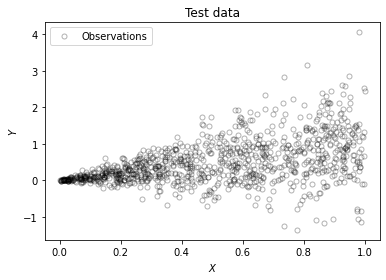

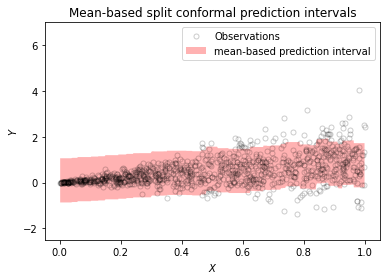

In [33]:
%matplotlib inline

fig = plt.figure()
plt.plot(X_predict, y_predict, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data')
plt.show()

plot_func(x=X_predict,y=y_predict,y_u=pred_band[:,1],y_l=pred_band[:,0], method_name="mean-based",title="Mean-based split conformal prediction intervals")

This makes it clear that the mean-based method is not made for heteroscedasticity settings. Let us use the conformalized quantile regression instead.

In [34]:
# training and prediction
tuning_grid = {'learning_rate': [0.01, 0.1, 0.5, 1.0], 'n_estimators': [100,200, 800], 'min_samples_leaf': [1, 10, 25]}
regressor = SplitConformalRegressor(GradientBoostingRegressor, method="quantile-based", param_grid=tuning_grid, quantiles_to_fit=np.array([0.05,0.95]), conf_size=0.5)
tuning_res= regressor.tune(X=X_train,y=y_train, cv=3)
opt_res = regressor.fit(X_train,y_train, params=tuning_res)
pred_band = opt_res.predict_intervals(X_pred=X_predict, alpha=alpha)

# let us check the empirical average coverage, and average length of intervals
in_the_range = np.sum((y_predict.flatten() >= pred_band[:,0]) & (y_predict.flatten() <= pred_band[:,1]))
coverage = in_the_range / len(y_predict)
length = np.mean(pred_band[:,1] - pred_band[:,0])
print(f"Average length of intervals is: {length}")
print(f"Average coverage of intervals is: {coverage}")

Average length of intervals is: 1.6342152881317897
Average coverage of intervals is: 0.908


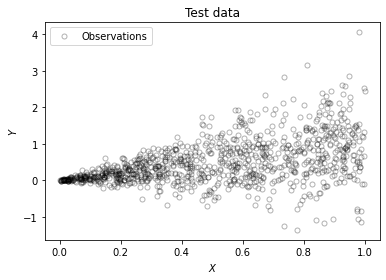

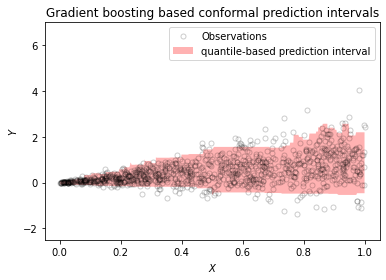

In [35]:
%matplotlib inline

fig = plt.figure()
plt.plot(X_predict, y_predict, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data')
plt.show()

plot_func(x=X_predict,y=y_predict,y_u=pred_band[:,1],y_l=pred_band[:,0], method_name="quantile-based",title="Gradient boosting based conformal prediction intervals")

In [50]:
# What about another base learner, instead of GradientBoostingRegressor?

# training and prediction
tuning_grid = {'nodesize': [45, 60], 'mtry': [1]}
regressor = SplitConformalRegressor(QuantregForest, method="quantile-based", param_grid=tuning_grid, quantiles_to_fit=np.array([0.05,0.95]), conf_size=0.5)
tuning_res= regressor.tune(X=X_train,y=y_train, cv=2)
opt_res = regressor.fit(X_train,y_train, params=tuning_res)
pred_band = opt_res.predict_intervals(X_pred=X_predict, alpha=alpha)

# let us check the empirical average coverage, and average length of intervals
in_the_range = np.sum((y_predict.flatten() >= pred_band[:,0]) & (y_predict.flatten() <= pred_band[:,1]))
coverage = in_the_range / len(y_predict)
length = np.mean(pred_band[:,1] - pred_band[:,0])
print(f"Average length of intervals is: {length}")
print(f"Average coverage of intervals is: {coverage}")


Average length of intervals is: 1.7025404223993177
Average coverage of intervals is: 0.916


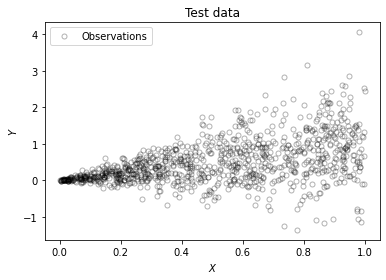

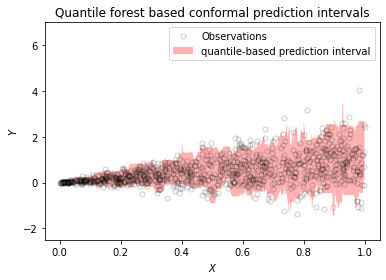

In [51]:
%matplotlib inline

fig = plt.figure()
plt.plot(X_predict, y_predict, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data')
plt.show()

plot_func(x=X_predict,y=y_predict,y_u=pred_band[:,1],y_l=pred_band[:,0], method_name="quantile-based",title="Quantile forest based conformal prediction intervals")